<a href="https://colab.research.google.com/github/as9786/ComputerVision/blob/main/ImageSegmentation/code/UNet_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module

In [20]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.2 MB/s eta 0:00:00


In [21]:
import random
import os

from PIL import Image
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt  
from torchsummary import summary as model_summary
from sklearn.model_selection import train_test_split
import torchvision

import torch 
import torch.nn as nn
import torch.nn.functional as F

import monai
from monai.config import print_config

import time

# 장치

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataset

In [3]:
root_path = '/content/drive/MyDrive/seg'
model_save_path = './FCN_v2.pth'
CXR_path = os.path.join(root_path, 'CXR_png')
MASK_path = os.path.join(root_path, 'masks')
     

In [4]:
CXR_list = sorted(os.listdir(CXR_path))
MASK_list = sorted(os.listdir(MASK_path))

# mask name
MASK_list_ = list(map(lambda x:x.split('.')[0][:-5]+'.png', MASK_list))
# 공통적인 data 찾기
CXR_MASK_union_list = set(MASK_list_) & set(CXR_list)

CXR_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'CXR_png', x), CXR_MASK_union_list)))
MASK_path_list = sorted(list(map(lambda x:os.path.join(root_path, 'masks', x.split('.')[0]+'_mask.png'), CXR_MASK_union_list)))

print(len(CXR_path_list), CXR_path_list[:1])
print(len(MASK_path_list), MASK_path_list[:1])
     

566 ['/content/drive/MyDrive/seg/CXR_png/CHNCXR_0001_0.png']
566 ['/content/drive/MyDrive/seg/masks/CHNCXR_0001_0_mask.png']


# Holdout

In [5]:
X, X_test, y, y_test = train_test_split(CXR_path_list, MASK_path_list, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
print(len(X_train), len(X_val), len(X_test))

samplex = torchvision.io.read_image(X_train[0])
sampley = torchvision.io.read_image(y_train[0])
print(samplex.shape, samplex.dtype)
print(sampley.shape, sampley.dtype, np.unique(sampley))

356 40 170
torch.Size([1, 2937, 3000]) torch.uint8
torch.Size([1, 2937, 3000]) torch.uint8 [  0 255]


In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
class LungDataset(Dataset):
  def __init__(self, img_dir, mask_dir, transforms_x):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.transforms_x = transforms_x

    assert len(img_dir) == len(mask_dir)

  def __len__(self):
    return len(self.img_dir)
  
  def __getitem__(self,idx):
    X = Image.open(self.img_dir[idx]).convert('RGB')
    X = X.resize((224,224))

    y = Image.open(self.mask_dir[idx])
    y = y.resize((224,224),Image.NEAREST)
    y = np.array(y)
    y = torch.from_numpy(y)
    y[y==255] = 1
    y_one_hot = F.one_hot(y.to(torch.int64))
    y_one_hot = y_one_hot.permute(2,0,1).to(torch.float)

    if self.transforms_x:
      X = self.transforms_x(X)


    return X, y_one_hot

In [8]:
from torchvision import transforms as transform

In [9]:
transforms_x  = transform.Compose([
    transform.ToTensor()
])

In [10]:
train_data = LungDataset(X_train,y_train,transforms_x=transforms_x)
valid_data = LungDataset(X_val,y_val,transforms_x=transforms_x)
test_data = LungDataset(X_test,y_test,transforms_x=transforms_x)

In [11]:
train_loader = DataLoader(train_data,batch_size=4,shuffle=True)
valid_loader = DataLoader(valid_data,batch_size=1)
test_loader = DataLoader(test_data,batch_size=1)

In [12]:
train_sample_x, train_sample_y = next(iter(train_loader))
print(f'train_sample_x.shape: {train_sample_x.shape}')
print(f'train_sample_y.shape: {train_sample_y.shape}')

train_sample_x.shape: torch.Size([4, 3, 224, 224])
train_sample_y.shape: torch.Size([4, 2, 224, 224])


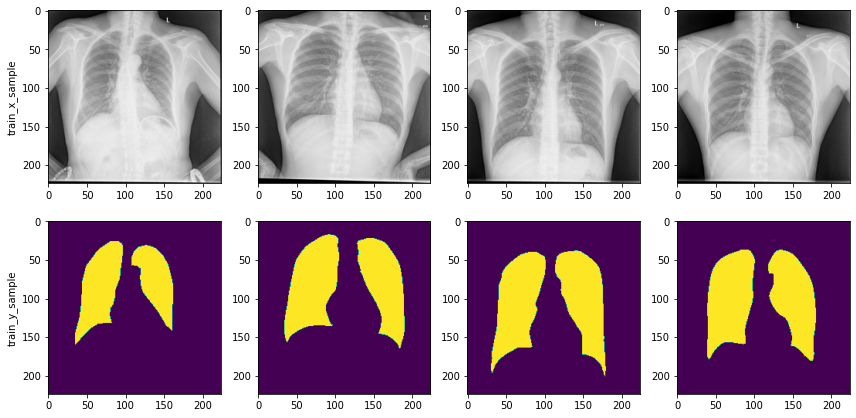

In [13]:
# 시각화
ncols, nrows = 4, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    img0 = train_sample_x[i].permute(1,2,0)
    img1 = train_sample_y[i].permute(1,2,0)[:,:,-1]
    
    axes[0,i].imshow(img0)
    axes[0,0].set_ylabel('train_x_sample')
    
    axes[1,i].imshow(img1)
    axes[1,0].set_ylabel('train_y_sample')
plt.tight_layout()
plt.show()

# 모형

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 합성곱층과 batch normalization, 활성화함수를 적용하는 함수
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=3, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)
        
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)
        
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [16]:
model = UNet()
model_summary(model, (3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [17]:
model = model.to(device)

In [22]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=2e-4)
ce_loss = torch.nn.CrossEntropyLoss()
dice_loss = monai.metrics.DiceMetric(include_background=False,reduction='mean') # 배경에 관해서는 계산 x

In [23]:
def train(model, train_loader, optimizer):
  since = time.time()
  model.train()
  epoch_loss = 0

  for batch, (X,y) in enumerate(train_loader):
    step = batch + 1
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(X)
    loss = ce_loss(output, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    dice_output = torch.where(output>=0.5,1,0)
    dice_loss(y_pred=dice_output,y=y)

  epoch_loss /= step
  dice_score = dice_loss.aggregate().item()
  dice_loss.reset()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  return epoch_loss, dice_score

In [24]:
def evaluate(model, test_loader):
  model.eval()
  loss = 0
  with torch.no_grad():
    for batch, (X,y) in enumerate(test_loader):
      step = batch + 1
      X,y = X.to(device), y.to(device)
      output = model(X)

      loss += ce_loss(output,y).item()
      dice_output = torch.where(output>=0.5,1,0)
      dice_loss(y_pred=dice_output,y=y)

    loss /= len(test_loader)
    dice_score = dice_loss.aggregate().item()
    dice_loss.reset()

    return loss, dice_score

In [25]:
losses = {'train':[],'val':[]}
dice_scores = {'train':[],'val':[]}
best_metric, best_epoch = 999,-1

for epoch in range(1,11):
  train_loss, train_dice_score = train(model, train_loader, optimizer) 
  val_loss, val_dice_score = evaluate(model,valid_loader)

  losses['train'].append(train_loss)
  losses['val'].append(val_loss)
  dice_scores['train'].append(train_dice_score)
  dice_scores['val'].append(val_dice_score)

  print(f'[{epoch}] Train Loss: {train_loss:.6f}, Dice score: {train_dice_score:.6f}')
  print(f'[{epoch}] Test Loss: {val_loss:.6f}, Dice score: {val_dice_score:.6f}')

  if losses['val'][-1] < best_metric:
    best_metric = losses['val'][-1]
    best_epoch = epoch
    torch.save(model.state_dict(),model_save_path)
    print('Save model')

Training complete in 8m 52s
[1] Train Loss: 0.164866, Dice score: 0.872485
[1] Test Loss: 0.342556, Dice score: 0.856767
Save model
Training complete in 1m 14s
[2] Train Loss: 0.106614, Dice score: 0.908301
[2] Test Loss: 0.168926, Dice score: 0.922814
Save model
Training complete in 1m 13s
[3] Train Loss: 0.084532, Dice score: 0.929796
[3] Test Loss: 0.115867, Dice score: 0.912328
Save model
Training complete in 1m 14s
[4] Train Loss: 0.072694, Dice score: 0.938147
[4] Test Loss: 0.086520, Dice score: 0.901591
Save model
Training complete in 1m 13s
[5] Train Loss: 0.068768, Dice score: 0.942265
[5] Test Loss: 0.062658, Dice score: 0.950933
Save model
Training complete in 1m 13s
[6] Train Loss: 0.067140, Dice score: 0.943478
[6] Test Loss: 0.090523, Dice score: 0.945665
Training complete in 1m 13s
[7] Train Loss: 0.066701, Dice score: 0.942683
[7] Test Loss: 1.475334, Dice score: 0.615238
Training complete in 1m 13s
[8] Train Loss: 0.064539, Dice score: 0.944474
[8] Test Loss: 0.078541

In [26]:
print(f"train completed, best_metric: {best_metric:.4f} \n" 
      f"at epoch: {best_epoch}")

train completed, best_metric: 0.0627 
at epoch: 5


## 시각화

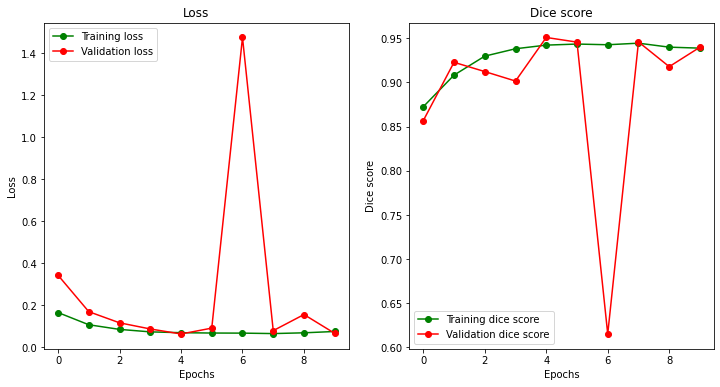

In [27]:
epochs = [i for i in range(len(losses['train']))]
train_loss = losses['train']
val_loss = losses['val']
train_dice = dice_scores['train']
val_dice = dice_scores['val']

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].plot(epochs,train_loss,'g-o',label='Training loss')
ax[0].plot(epochs,val_loss,'r-o',label='Validation loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs,train_dice,'go-',label='Training dice score')
ax[1].plot(epochs,val_dice,'ro-',label='Validation dice score')
ax[1].set_title('Dice score')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Dice score')
plt.show()

# 평가

In [28]:
len_test = len(test_loader)

pred_dict = {'input':[],'target':[],'output':[]}

model.load_state_dict(torch.load(model_save_path))  
model.to('cpu')
model.eval()

with torch.no_grad():
  for i, (X,y) in enumerate(test_loader):
    output = model(X)
    output = torch.argmax(output,dim=1,keepdim=True)

    data = X[0].permute(1,2,0)
    target = y[0].permute(1,2,0)[:,:,-1]
    output_ = output[0].permute(1,2,0)[:,:,-1]

    pred_dict['input'].append(data)
    pred_dict['target'].append(target)
    pred_dict['output'].append(output_)

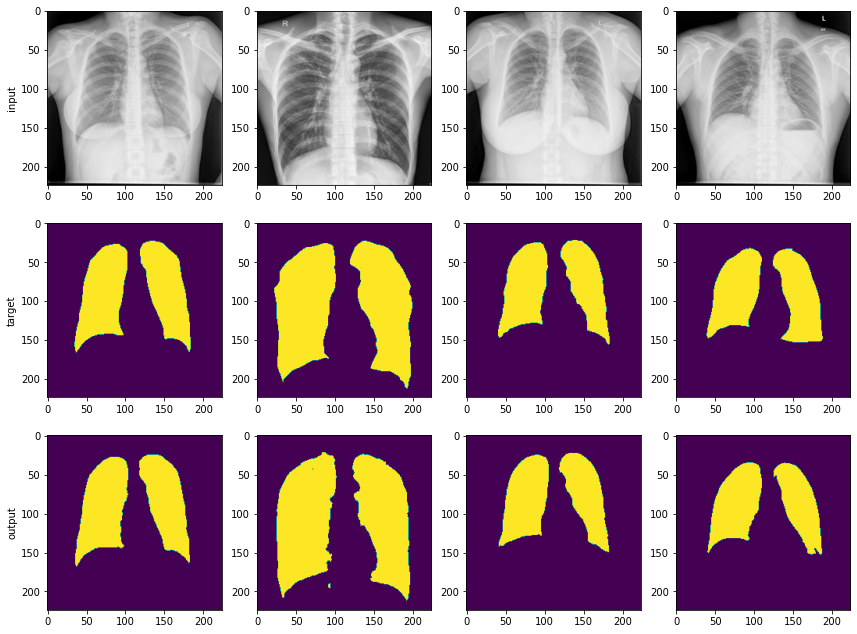

In [29]:
ncols, nrows = 4, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for i in range(ncols):
    axes[0,i].imshow(pred_dict['input'][i])
    axes[0,0].set_ylabel('input')

    axes[1,i].imshow(pred_dict['target'][i])
    axes[1,0].set_ylabel('target')

    axes[2,i].imshow(pred_dict['output'][i])
    axes[2,0].set_ylabel('output')

plt.tight_layout()
plt.show()